In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import pickle

from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
import lightgbm as lgb
import catboost

from scipy.stats import randint
from sklearn.utils.fixes import loguniform

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
class CONFIG:
    seed = 42
    target_col = "responder_6"
    feature_cols = ["symbol_id", "time_id"] \
        + [f"feature_{idx:02d}" for idx in range(79)] \
        + [f"responder_{idx}_lag_1" for idx in range(9)]
    categorical_cols = []

In [3]:
pre_train_score = 0
pre_valid_score = 0

In [4]:
##del feature
col = ['feature_09', 'feature_10', 'feature_11', 'feature_63', 'feature_64', 'feature_41', 'feature_43', 'feature_16', 'feature_71', 'feature_40',
      'feature_76', 'feature_62', 'feature_78']
for c in col:
    CONFIG.feature_cols.remove(c)

In [5]:
train = pl.scan_parquet("./training.parquet").collect().to_pandas()
valid = pl.scan_parquet("./validation.parquet").collect().to_pandas()
train.shape, valid.shape

((10428264, 104), (527560, 104))

In [ ]:
train = pd.concat([train, valid]).reset_index(drop=True)
train.shape

(10955824, 104)

In [16]:
def get_model(seed):
    # catboost
    param_grid = {'grow_policy': 'SymmetricTree', 
              'min_data_in_leaf': 22,#17, 
              'depth': 5, 
              'od_wait': 50, 
              'learning_rate': 0.17147584916085204, 
              'iterations': 191} #130
    cat_Model = catboost.CatBoostRegressor(**param_grid, eval_metric='R2', has_time=True)

    return cat_Model

In [8]:
X_train = train[ CONFIG.feature_cols ]
y_train = train[ CONFIG.target_col ]
w_train = train[ "weight" ]
X_valid = valid[ CONFIG.feature_cols ]
y_valid = valid[ CONFIG.target_col ]
w_valid = valid[ "weight" ]

X_train.shape, y_train.shape, w_train.shape, X_valid.shape, y_valid.shape, w_valid.shape

((10955824, 77), (10955824,), (10955824,), (527560, 77), (527560,), (527560,))

In [33]:
model_cat = catboost.CatBoostRegressor(eval_metric='R2', has_time=True)

param_grid = {
    'n_estimators': randint(100, 200),
    'depth': randint(5, 7),
   'learning_rate': loguniform(0.01, 0.2),
    'min_child_samples': randint(15, 25),
    'grow_policy': ['SymmetricTree'],# #'Lossguide', 'Depthwise', 'SymmetricTree'],
    'early_stopping_rounds' : [50, 100]
}



best_result = model_cat.randomized_search(param_grid,
                            X_train, y_train,
                            cv=3, n_iter=10)

print("Best Parameters from Search:", best_result['params'])

model_cat.fit(X_train, y_train, sample_weight=w_train)

pred = model_cat.predict( X_valid )
sc = r2_score(y_valid, pred, sample_weight=w_valid )
print(sc)

0:	learn: 0.0003603	test: 0.0003483	best: 0.0003483 (0)	total: 563ms	remaining: 1m 33s
1:	learn: 0.0007159	test: 0.0006861	best: 0.0006861 (1)	total: 1.13s	remaining: 1m 33s
2:	learn: 0.0010345	test: 0.0009944	best: 0.0009944 (2)	total: 1.62s	remaining: 1m 28s
3:	learn: 0.0013135	test: 0.0012668	best: 0.0012668 (3)	total: 2.1s	remaining: 1m 25s
4:	learn: 0.0015775	test: 0.0015286	best: 0.0015286 (4)	total: 2.54s	remaining: 1m 22s
5:	learn: 0.0018454	test: 0.0017868	best: 0.0017868 (5)	total: 2.97s	remaining: 1m 19s
6:	learn: 0.0020871	test: 0.0020245	best: 0.0020245 (6)	total: 3.45s	remaining: 1m 18s
7:	learn: 0.0023229	test: 0.0022521	best: 0.0022521 (7)	total: 3.88s	remaining: 1m 17s
8:	learn: 0.0025804	test: 0.0024940	best: 0.0024940 (8)	total: 4.39s	remaining: 1m 17s
9:	learn: 0.0028027	test: 0.0027119	best: 0.0027119 (9)	total: 4.87s	remaining: 1m 16s
10:	learn: 0.0029859	test: 0.0028864	best: 0.0028864 (10)	total: 5.33s	remaining: 1m 15s
11:	learn: 0.0031661	test: 0.0030623	best:

In [17]:
%%time
model = get_model(CONFIG.seed)
model.fit( X_train, y_train, sample_weight=w_train)

0:	learn: 0.0005076	total: 500ms	remaining: 1m 35s
1:	learn: 0.0010306	total: 1.05s	remaining: 1m 39s
2:	learn: 0.0014728	total: 1.56s	remaining: 1m 37s
3:	learn: 0.0019054	total: 2.14s	remaining: 1m 40s
4:	learn: 0.0023094	total: 2.67s	remaining: 1m 39s
5:	learn: 0.0026837	total: 3.23s	remaining: 1m 39s
6:	learn: 0.0030138	total: 3.72s	remaining: 1m 37s
7:	learn: 0.0033486	total: 4.35s	remaining: 1m 39s
8:	learn: 0.0036568	total: 4.9s	remaining: 1m 39s
9:	learn: 0.0039245	total: 5.41s	remaining: 1m 37s
10:	learn: 0.0041565	total: 5.95s	remaining: 1m 37s
11:	learn: 0.0044192	total: 6.55s	remaining: 1m 37s
12:	learn: 0.0046652	total: 7.09s	remaining: 1m 37s
13:	learn: 0.0048885	total: 7.71s	remaining: 1m 37s
14:	learn: 0.0050877	total: 8.25s	remaining: 1m 36s
15:	learn: 0.0053274	total: 8.81s	remaining: 1m 36s
16:	learn: 0.0055281	total: 9.34s	remaining: 1m 35s
17:	learn: 0.0057262	total: 9.96s	remaining: 1m 35s
18:	learn: 0.0059062	total: 10.4s	remaining: 1m 34s
19:	learn: 0.0060654	to

In [12]:
y_means = { symbol_id : -1 for symbol_id in range(39) }
for symbol_id, gdf in train[["symbol_id", CONFIG.target_col]].groupby("symbol_id"):
    y_mean = gdf[ CONFIG.target_col ].mean()
    y_means[symbol_id] = y_mean
    print(f"symbol_id = {symbol_id}, y_means = {y_mean:.5f}")

symbol_id = 0, y_means = -0.00706
symbol_id = 1, y_means = -0.00856
symbol_id = 2, y_means = 0.00451
symbol_id = 3, y_means = 0.01523
symbol_id = 4, y_means = 0.01331
symbol_id = 5, y_means = 0.00868
symbol_id = 6, y_means = 0.00996
symbol_id = 7, y_means = -0.00055
symbol_id = 8, y_means = -0.00560
symbol_id = 9, y_means = -0.05171
symbol_id = 10, y_means = 0.00283
symbol_id = 11, y_means = -0.00581
symbol_id = 12, y_means = -0.00283
symbol_id = 13, y_means = -0.00820
symbol_id = 14, y_means = -0.00844
symbol_id = 15, y_means = 0.00799
symbol_id = 16, y_means = -0.00740
symbol_id = 17, y_means = -0.00381
symbol_id = 18, y_means = -0.01093
symbol_id = 19, y_means = 0.01338
symbol_id = 20, y_means = 0.00982
symbol_id = 21, y_means = 0.01602
symbol_id = 22, y_means = -0.00410
symbol_id = 23, y_means = 0.01738
symbol_id = 24, y_means = -0.00286
symbol_id = 25, y_means = -0.02394
symbol_id = 26, y_means = -0.00495
symbol_id = 27, y_means = -0.01014
symbol_id = 28, y_means = 0.00009
symbol_

In [13]:
cv_detail = { symbol_id : 0 for symbol_id in range(39) }
for symbol_id, gdf in valid.groupby("symbol_id"):
    X_valid = gdf[ CONFIG.feature_cols ]
    y_valid = gdf[ CONFIG.target_col ]
    w_valid = gdf[ "weight" ]
    y_pred_valid = model.predict(X_valid)
    score = r2_score(y_valid, y_pred_valid, sample_weight=w_valid )
    cv_detail[symbol_id] = score
    
    print(f"symbol_id = {symbol_id}, score = {score:.5f}")

symbol_id = 0, score = 0.00175
symbol_id = 1, score = 0.00663
symbol_id = 2, score = 0.00344
symbol_id = 3, score = 0.02070
symbol_id = 4, score = 0.03484
symbol_id = 5, score = 0.00536
symbol_id = 6, score = 0.00256
symbol_id = 7, score = 0.00999
symbol_id = 8, score = 0.02010
symbol_id = 9, score = 0.00010
symbol_id = 10, score = 0.00258
symbol_id = 11, score = 0.00083
symbol_id = 12, score = 0.00274
symbol_id = 13, score = 0.01315
symbol_id = 14, score = -0.00054
symbol_id = 15, score = 0.00149
symbol_id = 16, score = 0.00877
symbol_id = 17, score = 0.03138
symbol_id = 18, score = 0.00328
symbol_id = 19, score = 0.02561
symbol_id = 20, score = 0.01016
symbol_id = 21, score = 0.00567
symbol_id = 22, score = 0.00013
symbol_id = 23, score = 0.00893
symbol_id = 24, score = -0.00687
symbol_id = 25, score = 0.00987
symbol_id = 26, score = 0.00235
symbol_id = 27, score = 0.00334
symbol_id = 28, score = -0.00088
symbol_id = 29, score = 0.00797
symbol_id = 30, score = -0.01020
symbol_id = 31

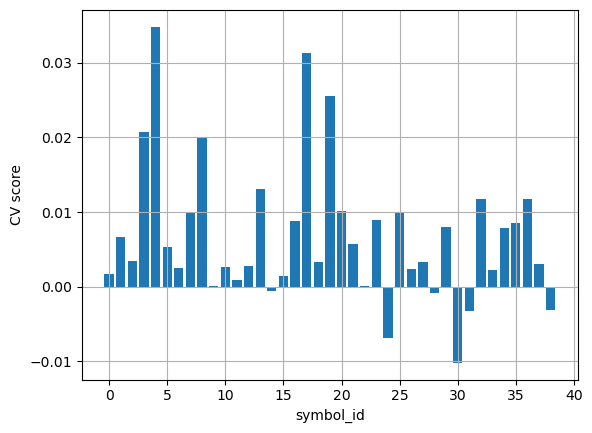

In [14]:
sids = list(cv_detail.keys())
plt.bar(sids, [cv_detail[sid] for sid in sids])
plt.grid()
plt.xlabel("symbol_id")
plt.ylabel("CV score")
plt.show()

In [15]:
result = {
    "model" : model,
    "cv" : valid_score,
    "cv_detail" : cv_detail,
    "y_mean" : y_means,
}
with open("result.pkl", "wb") as fp:
    pickle.dump(result, fp)